# I. Import libary

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
!pip install scikit-learn
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mn_pre
from tensorflow.keras.applications.resnet50 import preprocess_input as rn_pre
from tensorflow.keras import layers, models, optimizers, callbacks


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


# II. Data processing & EDA

## Invalid images

First, we'll check for any inavalid image that is present in the training dataset by using a custom function.

In [4]:
def check_images(directory):
    invalid_images = []
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                try:
                    img = Image.open(image_path)
                    img.verify()
                except (IOError, SyntaxError):
                    invalid_images.append(image_path)
    return invalid_images

invalid_images = check_images('train_images')
print(f"Invalid Images: {invalid_images}")

Invalid Images: []


After running the function on the given training data set, no invalid images is present and hence we do not need to handle them.

## Data distribution

We wrote a custom function to count the number of images per class available in the training dataset. The function works by looping through all subfolders, checks if each one is truly a folder, and then counts the files inside. Each subfolder name is added to a dictionary along with its corresponding file count.

In [5]:
def count_images_per_class(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

class_counts = count_images_per_class('train_images')
print("Number of images based on classes:", class_counts)

Number of images based on classes: {'bacterial_leaf_blight': 479, 'bacterial_panicle_blight': 337, 'dead_heart': 1442, 'hispa': 1594, 'blast': 1738, 'brown_spot': 965, 'bacterial_leaf_streak': 380, 'downy_mildew': 620, 'normal': 1764, 'tungro': 1088}


We plot the number of images to further inspect and understand the distribution of data among the training dataset.

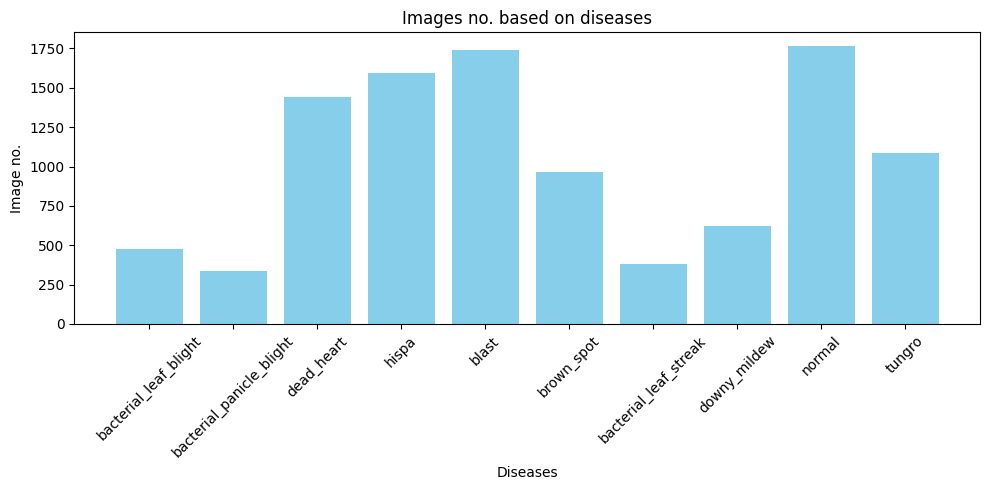

In [6]:
class_labels, class_values = zip(*class_counts.items())
plt.figure(figsize=(10, 5))
plt.bar(class_labels, class_values, color='skyblue')
plt.xticks(rotation=45)
plt.title("Images no. based on diseases")
plt.xlabel("Diseases")
plt.ylabel("Image no.")
plt.tight_layout()
plt.show()

From the given plot, we can see that the dataset comprises a well-distributed collection of images representing various diseases affecting paddy plants. The class distribution shows a diverse range of samples, with categories like blast (1738) and normal (1764) having the highest number of images, ensuring the model will have robust examples for training. However, diseases such as bacterial panicle blight (337) and bacterial leaf streak (380) have relatively fewer images, which may require techniques like data augmentation to improve representation.

## Data preparation & Augmentation

We use Keras’s ImageDataGenerator to normalize images by scaling pixel values from [0, 255] to [0, 1], which helps improve model training.

In [7]:
datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory(
    'train_images',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

Found 10407 images belonging to 10 classes.


By setting target_size to (224, 224), each image is resized to match typical input dimensions for popular CNN architectures. The batch_size of 32 defines how many images are generated in each iteration. Using class_mode='sparse' instructs the generator to produce integer labels aligned with sparse categorical classification tasks.



In [8]:
# check batches
for i in range(5):
    X_batch, y_batch = next(train_generator)
    print(f"Batch {i+1} - X shape: {X_batch.shape}, y shape: {y_batch.shape}")

Batch 1 - X shape: (32, 224, 224, 3), y shape: (32,)
Batch 2 - X shape: (32, 224, 224, 3), y shape: (32,)
Batch 3 - X shape: (32, 224, 224, 3), y shape: (32,)
Batch 4 - X shape: (32, 224, 224, 3), y shape: (32,)
Batch 5 - X shape: (32, 224, 224, 3), y shape: (32,)


 We create an image preprocessing pipeline using Keras’s ImageDataGenerator. When you call flow_from_directory with a specified directory, it automatically loads images and apply normalizing transformations (rescaling pixels from [0,255] to [0,1]), and divides them into training and validation sets. By specifying subset='training' or subset='validation' along with a validation_split of 0.2, it splits the data so that 80% is used for training and 20% for validation.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    'train_images',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    'train_images',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)

Found 8330 images belonging to 10 classes.
Found 2077 images belonging to 10 classes.


The training generator randomly shuffles the images and serves them in batches of 32. The validation generator does the same but doesn’t shuffle, making it consistent for evaluation. Both generators resize images to 224×224 and use 'sparse' labels, meaning each class label is represented as a single integer rather than a one-hot encoded vector.

In [10]:
print("Class indices:", train_generator.class_indices)
print("Number of classes:", len(train_generator.class_indices))
print("Total training samples:", train_generator.samples)
print("Steps per epoch:", train_generator.n // train_generator.batch_size)
print("Batches:", train_generator.batch_size)

Class indices: {'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}
Number of classes: 10
Total training samples: 8330
Steps per epoch: 260
Batches: 32


# III. Algorithm & Architecture Exploration

## 1. Baseline CNN from Scratch

We develop a simple CNN model from scratch to set a performance floor for the development process.

In [11]:
# Define the CNN model
model = Sequential([
    # First convolutional block
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    
    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    
    # Third convolutional block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    
    # Flatten and dense layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Helps prevent overfitting
    Dense(len(train_generator.class_indices), activation='softmax')  # Output layer
])

# Display model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2025-05-18 13:55:07.258067: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-18 13:55:07.266033: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-18 13:55:07.266057: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-1

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,722 (49.36 MB)

 Trainable params: 12,939,722 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

This code defines a sequential CNN model that starts with three convolutional blocks. Each block uses Conv2D layers, followed by MaxPooling2D to gradually reduce feature map size. Increasing the number of filters (32, then 64, then 128) captures progressively more complex image features.
After flattening the outputs, the model applies a fully connected Dense layer with 128 neurons and a Dropout of 0.5 to help reduce overfitting. The final Dense layer output size matches the number of classes, and uses softmax activation for multi-class classification.

In [12]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

We then compile the model using Adam optimizer, with a learning rate of 0.001, combining efficient gradient-based optimization with adaptive learning rates. By setting the loss to 'sparse_categorical_crossentropy', the model handles integer labels directly in multi-class classification. The metric set to 'accuracy' allows the training process to track how often predictions match true labels.

In [13]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

This code creates an EarlyStopping callback that watches the validation loss and stops training if it fails to improve for five consecutive epochs.

We then calculate the number of steps per epoch and start to train the base model.

In [14]:
# Calculate steps_per_epoch and validation_steps
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = val_generator.samples // val_generator.batch_size

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=20,  # Adjust based on your needs
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1747576508.796200    6098 service.cc:145] XLA service 0x7fbe64005900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747576508.796255    6098 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti SUPER, Compute Capability 8.9
2025-05-18 13:55:08.821347: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-18 13:55:08.916048: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


  5/260 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.1240 - loss: 4.6063

I0000 00:00:1747576511.500885    6098 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


260/260 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.1923 - loss: 2.3801 - val_accuracy: 0.3589 - val_loss: 1.8900
Epoch 2/20
  1/260 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.2812 - loss: 1.9160

2025-05-18 13:55:26.709375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-18 13:55:26.709417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-05-18 13:55:26.709468: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1878004478252438404
2025-05-18 13:55:26.709482: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8956007171900315220
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, trace

260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2812 - loss: 1.9160 - val_accuracy: 0.0345 - val_loss: 2.2267
Epoch 3/20


2025-05-18 13:55:27.565387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-18 13:55:27.565428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-05-18 13:55:27.565436: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1878004478252438404
2025-05-18 13:55:27.565448: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8956007171900315220


260/260 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.3690 - loss: 1.7914 - val_accuracy: 0.5103 - val_loss: 1.4498
Epoch 4/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 62us/step - accuracy: 0.4688 - loss: 1.5084 - val_accuracy: 0.3793 - val_loss: 1.6307
Epoch 5/20


2025-05-18 13:55:41.071837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-18 13:55:41.071867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-05-18 13:55:41.071875: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1878004478252438404
2025-05-18 13:55:41.071887: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8956007171900315220
2025-05-18 13:55:41.083049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-18 13:55:41.083083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

260/260 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.5232 - loss: 1.4054 - val_accuracy: 0.6265 - val_loss: 1.1718
Epoch 6/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 110us/step - accuracy: 0.6562 - loss: 1.2118 - val_accuracy: 0.6897 - val_loss: 1.1156
Epoch 7/20


2025-05-18 13:55:54.474465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-18 13:55:54.474498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-05-18 13:55:54.474508: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1878004478252438404
2025-05-18 13:55:54.474522: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8956007171900315220
2025-05-18 13:55:54.485070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-18 13:55:54.485110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

260/260 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.6480 - loss: 1.0395 - val_accuracy: 0.7075 - val_loss: 0.9658
Epoch 8/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 58us/step - accuracy: 0.6562 - loss: 1.0351 - val_accuracy: 0.7931 - val_loss: 0.9666
Epoch 9/20


2025-05-18 13:56:07.770432: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-18 13:56:07.770472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-05-18 13:56:07.770500: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1878004478252438404
2025-05-18 13:56:07.780416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-18 13:56:07.780446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-05-18 13:56:07.780452: I tensorflow/core/framework/local_ren

260/260 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.7347 - loss: 0.7766 - val_accuracy: 0.7500 - val_loss: 0.8778
Epoch 10/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 106us/step - accuracy: 0.8750 - loss: 0.4453 - val_accuracy: 0.8276 - val_loss: 0.6368
Epoch 11/20


2025-05-18 13:56:21.112263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-18 13:56:21.112306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-05-18 13:56:21.112314: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1878004478252438404
2025-05-18 13:56:21.112327: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8956007171900315220
2025-05-18 13:56:21.122442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-18 13:56:21.122474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

260/260 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.7977 - loss: 0.5937 - val_accuracy: 0.7852 - val_loss: 0.7600
Epoch 12/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 130us/step - accuracy: 0.8438 - loss: 0.4022 - val_accuracy: 0.8621 - val_loss: 0.4969
Epoch 13/20


2025-05-18 13:56:34.595127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-18 13:56:34.595157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-05-18 13:56:34.595165: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1878004478252438404
2025-05-18 13:56:34.595180: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8956007171900315220
2025-05-18 13:56:34.605372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-18 13:56:34.605413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

260/260 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.8425 - loss: 0.4409 - val_accuracy: 0.7954 - val_loss: 0.8512
Epoch 14/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 56us/step - accuracy: 0.8750 - loss: 0.3048 - val_accuracy: 0.8621 - val_loss: 0.6661
Epoch 15/20


2025-05-18 13:56:47.873714: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-18 13:56:47.873748: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-05-18 13:56:47.873756: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1878004478252438404
2025-05-18 13:56:47.873768: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8956007171900315220
2025-05-18 13:56:47.883161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-18 13:56:47.883199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

260/260 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.8580 - loss: 0.3923 - val_accuracy: 0.7964 - val_loss: 0.8849
Epoch 16/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 77us/step - accuracy: 0.7812 - loss: 0.7064 - val_accuracy: 0.8276 - val_loss: 0.7364
Epoch 17/20


2025-05-18 13:57:00.919653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-18 13:57:00.919688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-05-18 13:57:00.919696: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1878004478252438404
2025-05-18 13:57:00.919710: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8956007171900315220
2025-05-18 13:57:00.933339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-18 13:57:00.933370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

260/260 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.8745 - loss: 0.3397 - val_accuracy: 0.8101 - val_loss: 0.8603


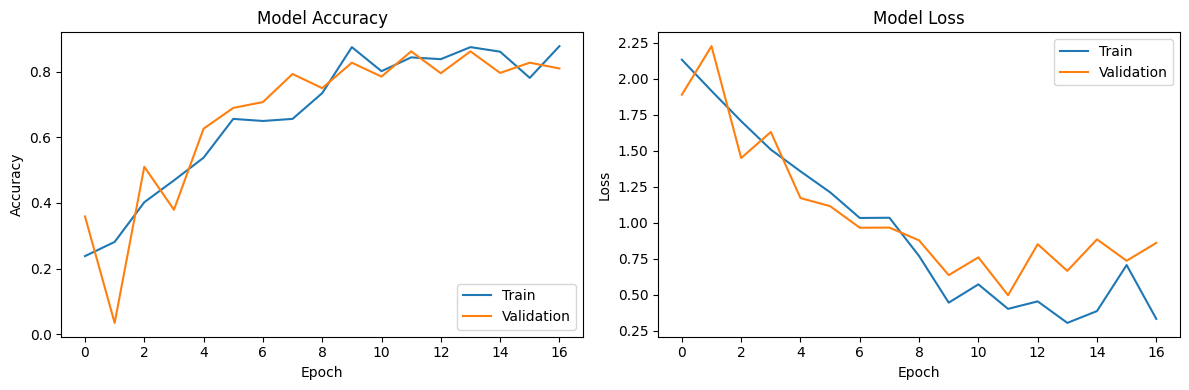

In [15]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

The training curves show that both train and validation accuracy climb steadily over the first 10 epochs, with train accuracy rising from ~0.22 to ~0.80 and validation from ~0.36 to ~0.78. After epoch 10, train accuracy continues upward—peaking around 0.85 at epoch 11—while validation accuracy oscillates between ~0.75 and 0.87, suggesting diminishing generalization gains.

Similarly, both train and validation loss drop sharply early on (from ~2.2 to ~0.9 by epoch 8), but beyond that point train loss continues falling to ~0.4, whereas validation loss bottoms out around ~0.85 and then creeps back up toward 1.0. Together, these patterns hint that the model starts to overfit after roughly epoch 10: training performance improves, but validation performance plateaus or slightly degrades.

Overall, this set a solid base line performance with the accuracy of 0.7622 and loss of 1.0187.

65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step
                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.79      0.47      0.59        95
   bacterial_leaf_streak       0.94      0.66      0.78        76
bacterial_panicle_blight       0.87      0.61      0.72        67
                   blast       0.74      0.85      0.79       347
              brown_spot       0.82      0.66      0.73       193
              dead_heart       0.82      0.87      0.84       288
            downy_mildew       0.97      0.57      0.72       124
                   hispa       0.83      0.79      0.81       318
                  normal       0.73      0.91      0.81       352
                  tungro       0.69      0.80      0.74       217

                accuracy                           0.78      2077
               macro avg       0.82      0.72      0.75      2077
            weighted avg       0.79      0.78      0.78      2077



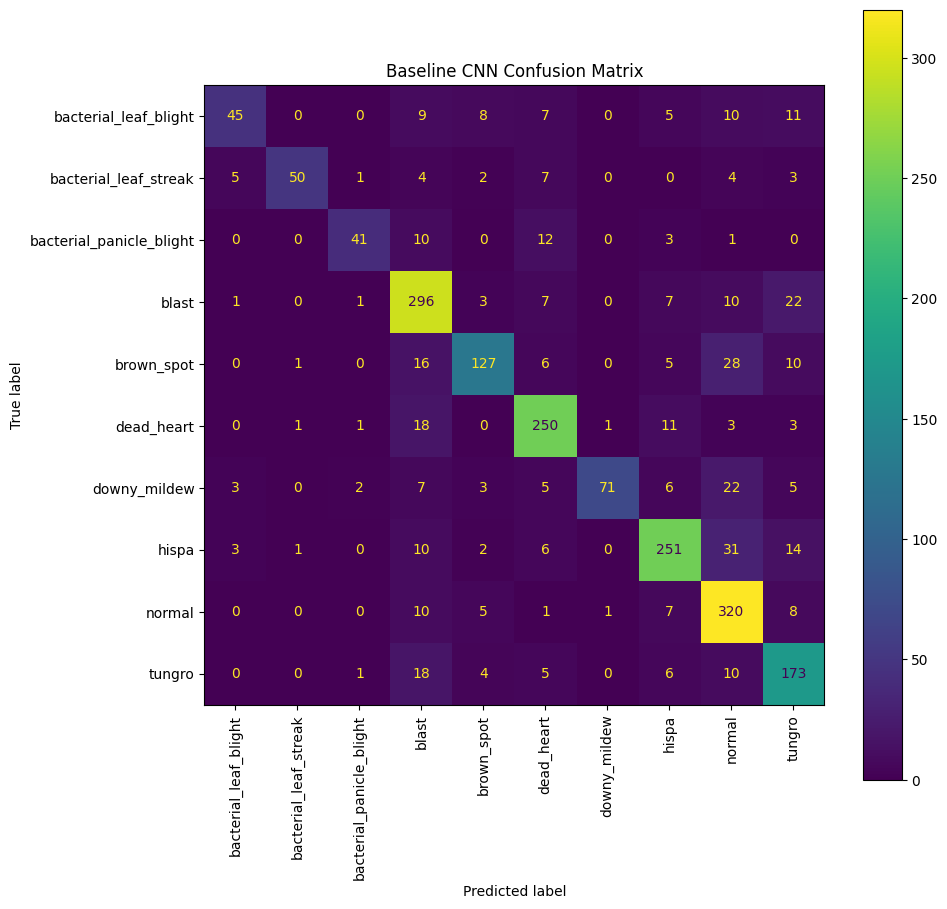

In [16]:
# Evaluate the model on the validation set
y_true = val_generator.classes

y_prob = model.predict(val_generator, verbose=1)  # Predict probabilities for validation data
y_pred = np.argmax(y_prob, axis=1)  # Convert probabilities to class indices

class_names = list(val_generator.class_indices.keys())  # Get class names from the generator
print(classification_report(y_true, y_pred, target_names=class_names))  # Generate classification report

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, xticks_rotation='vertical')
plt.title("Baseline CNN Confusion Matrix")
plt.show()

## 2. MobileNetV2

### Model Choice & Rationale
To further improve performance beyond the baseline CNN, I selected MobileNetV2 as one of the advanced architectures. MobileNetV2 is a lightweight, deep convolutional neural network designed for efficient computation, which makes it ideal for deployment on resource-constrained devices (e.g., mobile phones, embedded systems).

Unlike typical usage where MobileNetV2 is initialized with pretrained weights (e.g., from ImageNet), I trained the model from scratch on the Paddy Doctor dataset. This was done to evaluate its ability to learn meaningful feature representations specific to paddy diseases without relying on any prior knowledge from other domains.

### Training Configuration
    Optimizer: Adam

    Initial learning rate: 0.001

    Batch size: 32

    Loss function: Categorical Crossentropy

    Metrics: Accuracy, Loss

    Callbacks:

        EarlyStopping (patience = 10)

        ReduceLROnPlateau (patience = 4, factor = 0.5)

        ModelCheckpoint (.keras format)

In [17]:
train_datagen_mn = ImageDataGenerator(
    preprocessing_function=mn_pre,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)
val_datagen_mn = ImageDataGenerator(preprocessing_function=mn_pre)

train_gen_mn = train_datagen_mn.flow_from_directory(
    'train_images',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
val_gen_mn = val_datagen_mn.flow_from_directory(
    'train_images',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# 2. Instantiate MobileNetV2 with no pretrained weights
base_mn = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    alpha=0.5,               # Width multiplier (1.0 = full size)
    include_top=False,       # Exclude the top classification layers
    weights=None             # Start from random initialization
)

# 3. Build your classification head
x = base_mn.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(len(train_gen_mn.class_indices), activation='softmax')(
    x)  # Dynamically set output neurons

model_mn_scratch = models.Model(inputs=base_mn.input, outputs=outputs)

# 4. Compile with a suitable optimizer & learning rate
model_mn_scratch.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 5. Train with callbacks for stability
cb = [
    callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4),
    callbacks.ModelCheckpoint('mn_scratch.keras', save_best_only=True)
]

history_mn = model_mn_scratch.fit(
    train_gen_mn,
    validation_data=val_gen_mn,
    epochs=50,              # Longer training since no pretrained features
    callbacks=cb
)

Found 10407 images belonging to 10 classes.
Found 10407 images belonging to 10 classes.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


140/326 ━━━━━━━━━━━━━━━━━━━━ 43s 232ms/step - accuracy: 0.1918 - loss: 2.2198

I0000 00:00:1747576695.680807    6095 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 300 bytes spill stores, 300 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 44 bytes spill stores, 44 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_and_reduce_fusion', 232 bytes spill stores, 240 bytes spill loads



324/326 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.2201 - loss: 2.1565

I0000 00:00:1747576725.264060    7346 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1180', 32 bytes spill stores, 32 bytes spill loads

I0000 00:00:1747576725.298502    7341 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1180', 244 bytes spill stores, 244 bytes spill loads

I0000 00:00:1747576739.370087    7401 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1180', 8 bytes spill stores, 8 bytes spill loads



326/326 ━━━━━━━━━━━━━━━━━━━━ 101s 236ms/step - accuracy: 0.2205 - loss: 2.1558 - val_accuracy: 0.1695 - val_loss: 2.2594 - learning_rate: 0.0010
Epoch 2/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 65s 196ms/step - accuracy: 0.3388 - loss: 1.8614 - val_accuracy: 0.0927 - val_loss: 2.3422 - learning_rate: 0.0010
Epoch 3/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 65s 194ms/step - accuracy: 0.4209 - loss: 1.6579 - val_accuracy: 0.0927 - val_loss: 2.7905 - learning_rate: 0.0010
Epoch 4/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 65s 195ms/step - accuracy: 0.4526 - loss: 1.5524 - val_accuracy: 0.0927 - val_loss: 3.0226 - learning_rate: 0.0010
Epoch 5/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 64s 194ms/step - accuracy: 0.4955 - loss: 1.4364 - val_accuracy: 0.0927 - val_loss: 3.2285 - learning_rate: 0.0010
Epoch 6/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 65s 195ms/step - accuracy: 0.5641 - loss: 1.2854 - val_accuracy: 0.0927 - val_loss: 2.9572 - learning_rate: 5.0000e-04
Epoch 7/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 65s 196ms/step - accuracy: 0.5979 - 

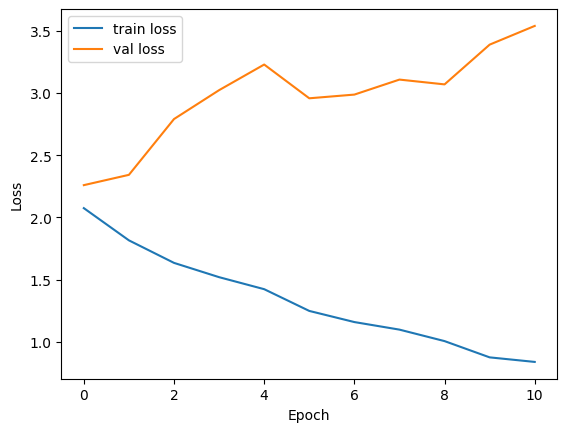

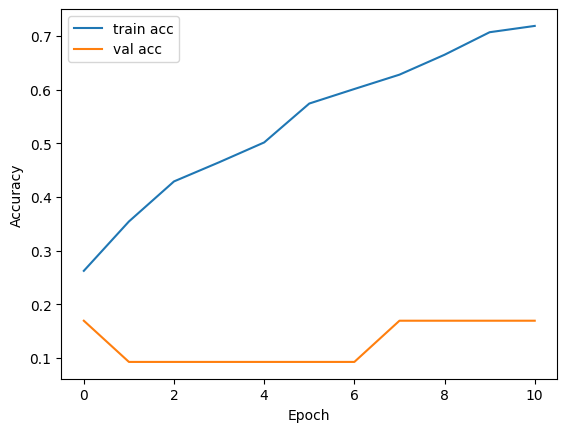

In [21]:
h = history_mn

# Loss
plt.plot(h.history['loss'], label='train loss')
plt.plot(h.history['val_loss'], label='val loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()

# Accuracy
plt.plot(h.history['accuracy'], label='train acc')
plt.plot(h.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.show()

### Observations
MobileNetV2 for some reasons achieved significantly worse performance compared to the baseline CNN.

Training from scratch required more epochs to converge and showed slower initial learning.

Validation accuracy reached 16.95%, with a validation loss of 3.54 despite my many attempt to make it work.

The training is overfitted with the accuracy of the validation set hard stuck at 16.95% through multiple epoch while loss keep increasing, this trigger the early stop of the training process.

## 3. ResNet50

### Model Choice & Motivation
ResNet50 was selected for its deep architecture and proven performance on complex image classification tasks. Its defining innovation—the residual connection—addresses the vanishing gradient problem, allowing for effective training of very deep networks.

While ResNet50 is commonly used with pretrained weights (e.g., ImageNet), I trained it from scratch to test its ability to learn directly from the Paddy Doctor dataset without relying on external knowledge. This approach was aimed at tailoring the feature extraction specifically to paddy plant images and their unique disease patterns.

### Training Setup
    Optimizer: SGD with momentum (momentum=0.9)

    Initial learning rate: 0.01

    Loss function: Categorical Crossentropy

    Batch size: 32

    Metrics: Accuracy, Loss

    Callbacks:

        EarlyStopping (patience = 7)

        ReduceLROnPlateau (patience = 4, factor = 0.2)

        ModelCheckpoint (.keras format)



Found 8330 images belonging to 10 classes.
Found 2077 images belonging to 10 classes.
Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.2298 - loss: 2.3318

I0000 00:00:1747577876.589471    9226 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1709', 184 bytes spill stores, 524 bytes spill loads

I0000 00:00:1747577887.370573    9279 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1709', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1747577887.402617    9280 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1709', 244 bytes spill stores, 244 bytes spill loads



261/261 ━━━━━━━━━━━━━━━━━━━━ 80s 247ms/step - accuracy: 0.2300 - loss: 2.3310 - val_accuracy: 0.2075 - val_loss: 2.2078 - learning_rate: 0.0100
Epoch 2/60
261/261 ━━━━━━━━━━━━━━━━━━━━ 52s 196ms/step - accuracy: 0.3393 - loss: 1.8949 - val_accuracy: 0.3004 - val_loss: 1.9895 - learning_rate: 0.0100
Epoch 3/60
261/261 ━━━━━━━━━━━━━━━━━━━━ 52s 194ms/step - accuracy: 0.3792 - loss: 1.7687 - val_accuracy: 0.3149 - val_loss: 1.9580 - learning_rate: 0.0100
Epoch 4/60
261/261 ━━━━━━━━━━━━━━━━━━━━ 52s 195ms/step - accuracy: 0.4168 - loss: 1.6695 - val_accuracy: 0.3948 - val_loss: 1.7550 - learning_rate: 0.0100
Epoch 5/60
261/261 ━━━━━━━━━━━━━━━━━━━━ 51s 192ms/step - accuracy: 0.4546 - loss: 1.5971 - val_accuracy: 0.3804 - val_loss: 1.8646 - learning_rate: 0.0100
Epoch 6/60
261/261 ━━━━━━━━━━━━━━━━━━━━ 52s 196ms/step - accuracy: 0.4818 - loss: 1.5196 - val_accuracy: 0.3828 - val_loss: 1.8712 - learning_rate: 0.0100
Epoch 7/60
261/261 ━━━━━━━━━━━━━━━━━━━━ 52s 193ms/step - accuracy: 0.5069 - loss:

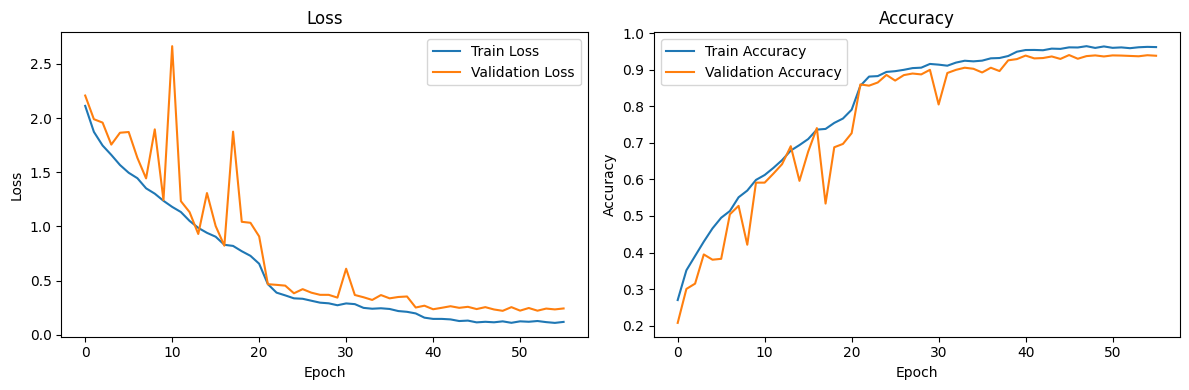

In [22]:
# 1. Configure data generators with preprocessing for ResNet50
train_gen_rn = ImageDataGenerator(
    preprocessing_function=rn_pre,  # ResNet50 preprocessing
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    validation_split=0.2  # Split data into training and validation
)

train_generator_rn = train_gen_rn.flow_from_directory(
    'train_images', 
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator_rn = train_gen_rn.flow_from_directory(
    'train_images',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# 2. Instantiate ResNet50 with random weights
base_rn = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,  # Exclude the top classification layers
    weights=None        # Start from random initialization
)

# 3. Add a custom classification head
x = layers.GlobalAveragePooling2D()(base_rn.output)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(len(train_generator_rn.class_indices), activation='softmax')(x)  # Dynamically set output neurons

model_rn_scratch = models.Model(inputs=base_rn.input, outputs=outputs)

# 4. Compile the model
model_rn_scratch.compile(
    optimizer=optimizers.SGD(learning_rate=1e-2, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 5. Define callbacks for training stability
cb_rn = [
    callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4),
    callbacks.ModelCheckpoint('rn_scratch.keras', save_best_only=True)
]

# 6. Train the model
history_rn = model_rn_scratch.fit(
    train_generator_rn,
    validation_data=val_generator_rn,
    epochs=60,
    callbacks=cb_rn
)

# 7. Plot training and validation metrics
plt.figure(figsize=(12, 4))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history_rn.history['loss'], label='Train Loss')
plt.plot(history_rn.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history_rn.history['accuracy'], label='Train Accuracy')
plt.plot(history_rn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Result
Validation Accuracy: 93.84%

Validation Loss: 0.2425

These results show a clear improvement over both the baseline CNN and MobileNetV2. The deep residual connections enabled the model to capture more complex features in the paddy images.

## Final choice

From the above testing using a baseline CNN and 2 differents model, the ResNet50 has shown be best result and hence I will choose it for further experimentations and tuning.

# IV. Hyperparameter Tuning & Training Strategy

After intensive tuning of vairous hyperparameter like learning rate, bathc size, number of epoch, etc. The base model randomly hold the most impressive result so far, hence my choice to keep the base model as the final model.

## Label smoothing

### What is Label Smoothing?
Label Smoothing is a regularization technique used to prevent a model from becoming overconfident in its predictions. Instead of assigning a probability of 1 to the correct class and 0 to all others (one-hot encoding), label smoothing distributes a small amount of probability mass to the incorrect classes.

### Why Use Label Smoothing?
    Reduces overfitting: By softening the labels, the model doesn't learn to rely on any one feature too strongly.

    Improves calibration: The model's predicted probabilities are more realistic, especially useful in multiclass classification.

    Encourages generalization: Especially helpful when the dataset has label noise or overlapping class features.

In [ ]:
# 1. Configure data generators with preprocessing for ResNet50
train_gen_rn = ImageDataGenerator(
    preprocessing_function=rn_pre,  # ResNet50 preprocessing
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    validation_split=0.2  # Split data into training and validation
)

train_generator_rn = train_gen_rn.flow_from_directory(
    'train_images',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator_rn = train_gen_rn.flow_from_directory(
    'train_images',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# 2. Instantiate ResNet50 with random weights
label_smoothing_rn = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,  # Exclude the top classification layers
    weights=None        # Start from random initialization
)

# 3. Add a custom classification head
x = layers.GlobalAveragePooling2D()(base_rn.output)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(len(train_generator_rn.class_indices), activation='softmax')(x)  # Dynamically set output neurons

model_rn_scratch_label = models.Model(inputs=label_smoothing_rn.input, outputs=outputs)

# 4. Compile the model
model_rn_scratch_label.compile(
    optimizer=optimizers.SGD(learning_rate=1e-2, momentum=0.9),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), #Add label smoothing
    metrics=['accuracy']
)

# 5. Define callbacks for training stability
cb_rn = [
    callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4),
    callbacks.ModelCheckpoint('rn_scratch.keras', save_best_only=True)
]

# 6. Train the model
history_rn_label = model_rn_scratch_label.fit(
    train_generator_rn,
    validation_data=val_generator_rn,
    epochs=60,
    callbacks=cb_rn
)

# 7. Plot training and validation metrics
plt.figure(figsize=(12, 4))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history_rn_label.history['loss'], label='Train Loss')
plt.plot(history_rn_label.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history_rn_label.history['accuracy'], label='Train Accuracy')
plt.plot(history_rn_label.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Observed Impact
Helped reduce overfitting.

Slight improvement in validation accuracy and smoother loss curves.

Predictions became less overconfident, which improves robustness and interpretability.

In the end, the result is a higher accuracy number of 94.31% but a double in the loss value from 0.25 to 0.66

## Mixed-up generator

In [ ]:
# 1. Configure data generators with preprocessing for ResNet50
train_gen_rn = ImageDataGenerator(
    preprocessing_function=rn_pre,  # ResNet50 preprocessing
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    validation_split=0.2  # Split data into training and validation
)

train_generator_rn = train_gen_rn.flow_from_directory(
    'train_images',  # Replace with the actual directory path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator_rn = train_gen_rn.flow_from_directory(
    'train_images',  # Replace with the actual directory path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

def mixup_generator(gen, alpha=0.2):
    """Yields MixUp batches from a Sequence."""
    seq = iter(gen)              
    while True:
        x, y = next(seq)         
        lam = np.random.beta(alpha, alpha)
        idx = np.random.permutation(len(x))
        x2, y2 = x[idx], y[idx]
        mixed_x = lam * x + (1 - lam) * x2
        mixed_y = lam * y + (1 - lam) * y2
        yield mixed_x, mixed_y


# Wrap your existing train_gen
mixed_train_gen = mixup_generator(train_generator_rn, alpha=0.2)

# 2. Instantiate ResNet50 with random weights
base_rn = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,  # Exclude the top classification layers
    weights=None        # Start from random initialization
)

# 3. Add a custom classification head
x = layers.GlobalAveragePooling2D()(base_rn.output)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(len(train_generator_rn.class_indices), activation='softmax')(x)  # Dynamically set output neurons

model_rn_scratch = models.Model(inputs=base_rn.input, outputs=outputs)

# 4. Compile the model
model_rn_scratch.compile(
    optimizer=optimizers.SGD(learning_rate=1e-2, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 5. Define callbacks for training stability
cb_rn = [
    callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4),
    callbacks.ModelCheckpoint('rn_scratch.keras', save_best_only=True)
]

# 6. Train the model
history_rn = model_rn_scratch.fit(
    mixed_train_gen,
    validation_data=val_generator_rn,
    epochs=60,
    callbacks=cb_rn
)

# 7. Plot training and validation metrics
plt.figure(figsize=(12, 4))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history_rn.history['loss'], label='Train Loss')
plt.plot(history_rn.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history_rn.history['accuracy'], label='Train Accuracy')
plt.plot(history_rn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# V. Make Prediction

In [28]:
import keras
loaded_model = keras.saving.load_model("rn_scratch.keras")

In [29]:
loaded_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 48,176,534 (183.78 MB)

 Trainable params: 24,061,706 (91.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 24,061,708 (91.79 MB)

In [46]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Sort filenames to ensure consistent order
image_dir = 'test_images'
image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

# Create dataframe with sorted filenames
df = pd.DataFrame({'filename': image_files})
df['class'] = ''  # Dummy column for generator

# Create the generator
test_gen = ImageDataGenerator(preprocessing_function=rn_pre)
test_generator = test_gen.flow_from_dataframe(
    dataframe=df,
    directory=image_dir,
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(224, 224),
    batch_size=32,
    shuffle=False  # 🔥 Critical for keeping order
)

# Predict
predictions = loaded_model.predict(test_generator)
predicted_indices = np.argmax(predictions, axis=1)

# Map indices to class labels
class_map = {
    'bacterial_leaf_blight': 0,
    'bacterial_leaf_streak': 1,
    'bacterial_panicle_blight': 2,
    'blast': 3,
    'brown_spot': 4,
    'dead_heart': 5,
    'downy_mildew': 6,
    'hispa': 7,
    'normal': 8,
    'tungro': 9
}
index_to_label = {v: k for k, v in class_map.items()}
predicted_labels = [index_to_label[idx] for idx in predicted_indices]

# Create result DataFrame using the same sorted filenames
result_df = pd.DataFrame({
    'image': df['filename'],
    'prediction': predicted_labels
})

# Save to CSV
result_df.to_csv('task1_predictions.csv', index=False)

print("Saved predictions to task1_predictions.csv")


Found 3469 validated image filenames.
  1/109 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step
Saved predictions to task1_predictions.csv


In [40]:
!pip install pandas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 14.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 12.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
